In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import Dataset, default_collate
from torchvision.transforms import ToTensor

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
BASE_DIR = "/kaggle/input/dog-breed-identification"
TRAIN_DIR = os.path.join(BASE_DIR, "train")

In [4]:
df = pd.read_csv(os.path.join(BASE_DIR, "labels.csv"))
df["id"] = df["id"].apply(lambda x: os.path.join(TRAIN_DIR, x+".jpg"))

labels = sorted(df["breed"].unique())
label_to_int = {breed:i for i, breed in enumerate(labels)}
int_to_label = {i:breed for i, breed in enumerate(labels)}

In [5]:
val_size = int(len(df) * 0.1)
indices = np.random.choice(len(df)-1, replace=False, size=val_size)
df_train = df.drop(indices)
df_test = df.iloc[indices]

print(len(df_train), len(df_test))

9200 1022


In [6]:
class DogBreedDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, target_transform=None):
        self.img_labels = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
class Cutout(object):
    def __init__(self, n_holes, length, prob=0.5):
        self.n_holes = n_holes
        self.length = length
        self.prob = prob

    def __call__(self, img):
        
        if np.random.rand() > self.prob:
            return img
        
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [8]:
transform_train = v2.Compose([
    v2.Resize((224,224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    Cutout(1, 56)
])

transform_test = v2.Compose([
    v2.Resize((224,224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_train = DogBreedDataset(
    df_train,
    TRAIN_DIR,
    transform_train,
    lambda x: label_to_int[x]
)

dataset_test = DogBreedDataset(
    df_test,
    TRAIN_DIR,
    transform_test,
    lambda x: label_to_int[x]
)

In [9]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=64,
                                          shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=64,
                                          shuffle=False, num_workers=2)

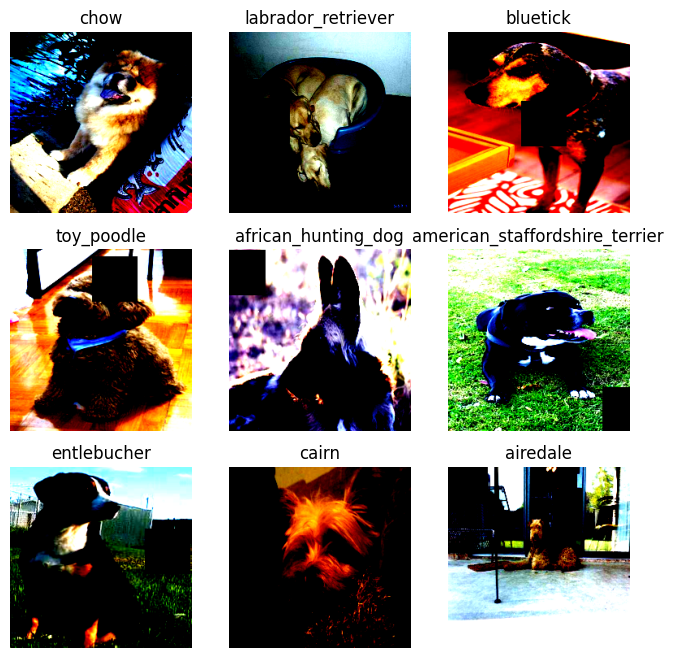

In [10]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset_train), size=(1,)).item()
    img, label = dataset_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(int_to_label[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

In [11]:
def accuracy(outputs, labels):
    with torch.no_grad():
        _, preds = torch.max(outputs, dim=1)
        return torch.sum(preds == labels).item() / len(preds)
    
def validate(model, dataset, criterion):
    correct = 0
    total = 0
    running_loss = 0.0
    
    with torch.no_grad():
        for i, data in enumerate(dataset):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            
            # val loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            # val accuracy
            _, preds = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    
    return running_loss / (i+1), correct / total

In [12]:
def train(model, optimizer, criterion, train_loader, test_loader, epochs=10, scheduler=None):
    counter = 0
    for epoch in range(epochs):
        
        if counter > 5:
            print("Early Stopping")
            break
        
        train_losses, train_accs = list(), list()

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            # Train statistics
            train_losses.append(loss.item())
            train_accs.append(accuracy(outputs, labels))

            if i % 72 == 71:
                avg_acc = sum(train_accs)/len(train_accs)
                avg_loss = sum(train_losses)/len(train_losses)
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f} acc: {avg_acc:.3f}')
                train_losses.clear()
                train_accs.clear()

        # Validation statistics
        avg_val_loss, avg_val_acc = validate(model, test_loader, criterion)
        print(f'[{epoch + 1}] val loss: {avg_val_loss:.3f} val acc: {avg_val_acc:.3f}')
        
        # Learning Rate Scheduler
        if scheduler is not None:
            scheduler.step()
            print(f"LR: {optimizer.param_groups[0]['lr']:.7f}")
        
        if (avg_acc - avg_val_acc) > 0.1:
            counter += 1
        
    print('Finished Training')

In [13]:
#(classifier): Linear(in_features=1024, out_features=1000, bias=True)
densenet121 = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
densenet121.classifier = nn.Linear(1024, len(labels))
densenet121.to(device)
densenet121.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 143MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet121.parameters(), lr=1e-3, weight_decay=4e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [5, 25, 45], gamma = 0.08)

train(densenet121, optimizer, criterion,train_loader, test_loader, 100, scheduler)

[1,    72] loss: 4.782 acc: 0.010
[1,   144] loss: 4.642 acc: 0.033
[1] val loss: 4.536 val acc: 0.051
LR: 0.0010000
[2,    72] loss: 4.270 acc: 0.106
[2,   144] loss: 3.179 acc: 0.251
[2] val loss: 2.491 val acc: 0.357
LR: 0.0010000
[3,    72] loss: 1.978 acc: 0.453
[3,   144] loss: 1.527 acc: 0.564
[3] val loss: 1.345 val acc: 0.606
LR: 0.0010000
[4,    72] loss: 1.202 acc: 0.644
[4,   144] loss: 1.083 acc: 0.677
[4] val loss: 1.107 val acc: 0.676
LR: 0.0010000
[5,    72] loss: 0.916 acc: 0.719
[5,   144] loss: 0.903 acc: 0.731
[5] val loss: 1.019 val acc: 0.709
LR: 0.0000800
[6,    72] loss: 0.695 acc: 0.794
[6,   144] loss: 0.635 acc: 0.810
[6] val loss: 0.882 val acc: 0.738
LR: 0.0000800
[7,    72] loss: 0.618 acc: 0.812
[7,   144] loss: 0.631 acc: 0.808
[7] val loss: 0.878 val acc: 0.741
LR: 0.0000800
[8,    72] loss: 0.607 acc: 0.814
[8,   144] loss: 0.617 acc: 0.803
[8] val loss: 0.882 val acc: 0.736
LR: 0.0000800
[9,    72] loss: 0.598 acc: 0.820
[9,   144] loss: 0.579 acc: 0.

In [15]:
torch.save(densenet121, "model.pt")

In [16]:
y_true = []
y_pred = []
 
with torch.no_grad():
    for data in test_loader:
        images, lbs = data[0].to(device),data[1].to(device)

        y_true.extend(lbs.cpu().numpy())

        outputs = densenet121(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())

In [17]:
from sklearn.metrics import f1_score, accuracy_score

print(f'F1 Score: {f1_score(y_true, y_pred, average="weighted"):.3f}')
print(f'Accuracy: {accuracy_score(y_true, y_pred):.3f}')


F1 Score: 0.754
Accuracy: 0.757
